# SMALL-FOOTPRINT KEYWORD SPOTTING
## *3. Model architecture and dropout/regularization*

This notebook takes the best feature and we try a new architecture with a RNN + CNN. Then for avoiding overfitting, different values of regularization and dropout are tested.

#### Import libraries

In [1]:
import os
import soundfile
import pywt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.io import wavfile
from scipy.fftpack import dct
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import layers, models, regularizers
import IPython
from IPython.display import Audio
import visualkeras
import pandas as pd
from python_speech_features import mfcc, fbank
from keras import backend as K
from utilities import*
import time

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-07-13 23:56:09.637888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 23:56:09.637966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 23:56:09.691104: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-13 23:56:09.798653: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-13 23:56:10.884675: W tensorflow/compiler/tf2

Num GPUs Available:  1


2024-07-13 23:56:13.540812: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-13 23:56:13.726610: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-13 23:56:13.728724: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Dataset Loading

In [3]:
# Create dataset
dir_wav = "./dataset"
audio_dataset, audio_labels = preprocess_tensor(dir_wav)

2024-07-13 23:56:13.745487: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-13 23:56:13.747739: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-13 23:56:13.749903: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# 2. Model Setup

### **2.1 RNN model**

This model is a mix between Convolutional Neural networks and Recurrent Neural Network in order to improve the previous result. Firstly 2 **Conv2D** layers are applied and then 2 **Bidirectional RNN** using the *LSTM* method. Finally, a **Dense** layer summarize the model with *sotfmax* activation. <br>
For this we will use **Adam** as the optimizer and use the **SparceCategoricalCrossEntropy** as loss function.

In [4]:
def RNN_model(training_data, validation_data, EPOCHS, r_val = 0.001, d_val = 0.3):

    start_time = time.time()
    norm_layer = layers.Normalization()
    norm_layer.adapt(data=training_data.map(map_func=lambda spec, label: spec))



    shape_in = training_data.as_numpy_iterator().next()[0][0].shape


    model = models.Sequential([
        layers.Input(shape=shape_in),
        layers.Resizing(32, 32),
        norm_layer,
        layers.Conv2D(10, (5, 1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(r_val)),
        layers.BatchNormalization(),
        layers.Conv2D(1, (5, 1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(r_val)),
        layers.BatchNormalization(),
        layers.Dropout(d_val),
        layers.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim'),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(64)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(r_val)),
        layers.Dropout(d_val),
        layers.Dense(len(audio_labels), activation='softmax'),
    ])

    # Compile model using ADAM and SparseCategoricalCrossEntropy
    model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

    print("Model Compiled succesfully\nStarting training")

    # Start fitting model with patience = 10
    history = model.fit(
        training_data,
        validation_data=validation_data,
        epochs=EPOCHS,
        callbacks=tf.keras.callbacks.EarlyStopping(patience=100),
        verbose = 1)

    end_time = time.time()
    print("Training done, model is ready to be tested!")


    return model, history, end_time-start_time

# 3. Feature testing

In [5]:
# Create folder for saving results
df_path = "./tests"
if not os.path.isdir(df_path):

    os.makedirs(df_path)

### **3.1 SIFT + background noise**

Now, we will apply **bakground noise** with an intensity defined by **noise_level** to each of the .wav files. <br>
The background noise can be specified by tuninng **noise_type** parameter.

**Feature extraction**

In [6]:
# Select audio feature extractor
feature_type = SIFT

# Define background noise
noise = True
noise_level = 0.3
noise_type = "doing_the_dishes"

# Run pipeline
train_data, val_data, test_data = pipeline_setup(audio_dataset, feature_type, noise_type, noise, noise_level)

**Model training**

In [40]:
# Define epochs
number_epochs = 100

# Run model
model, history, total_time = RNN_model(train_data.map(extract), val_data.map(extract), number_epochs)

ERROR: Could not find file /tmp/ipykernel_19326/2660754164.py
Model Compiled succesfully
Starting training
Epoch 1/100


2024-07-13 18:17:41.528990: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 46s 27ms/step - loss: 2.1968 - accuracy: 0.3815 - val_loss: 1.2328 - val_accuracy: 0.6519
Epoch 2/100
1158/1158 [==============================] - 28s 24ms/step - loss: 1.3570 - accuracy: 0.6215 - val_loss: 0.9551 - val_accuracy: 0.7320
Epoch 3/100
1158/1158 [==============================] - 27s 23ms/step - loss: 1.1675 - accuracy: 0.6774 - val_loss: 0.8543 - val_accuracy: 0.7569
Epoch 4/100
1158/1158 [==============================] - 27s 23ms/step - loss: 1.0760 - accuracy: 0.7018 - val_loss: 0.7601 - val_accuracy: 0.7870
Epoch 5/100
1158/1158 [==============================] - 27s 23ms/step - loss: 1.0070 - accuracy: 0.7212 - val_loss: 0.7413 - val_accuracy: 0.7893
Epoch 6/100
1158/1158 [==============================] - 27s 23ms/step - loss: 0.9660 - accuracy: 0.7312 - val_loss: 0.7104 - val_accuracy: 0.7988
Epoch 7/100
1158/1158 [==============================] - 33s 28ms/step - loss: 0.9297 - accuracy: 0.7418 - val_loss: 0.6885 - val_

In [42]:
# Save model
model.save("SIFT_RNN_100_ln_03.keras")

**Display training metrics**

In [43]:
# Display training metrics dataframe
df = pd.DataFrame(history.history)
df.to_csv(os.path.join(df_path, 'stft_n.txt'), sep='\t', index=False)
df.tail()

,loss,accuracy,val_loss,val_accuracy
95,0.527902,0.852106,0.376233,0.895881
96,0.529396,0.851566,0.367478,0.897865
97,0.529645,0.850459,0.380621,0.893141
98,0.530798,0.851525,0.388716,0.886338
99,0.531244,0.850850,0.385522,0.887850


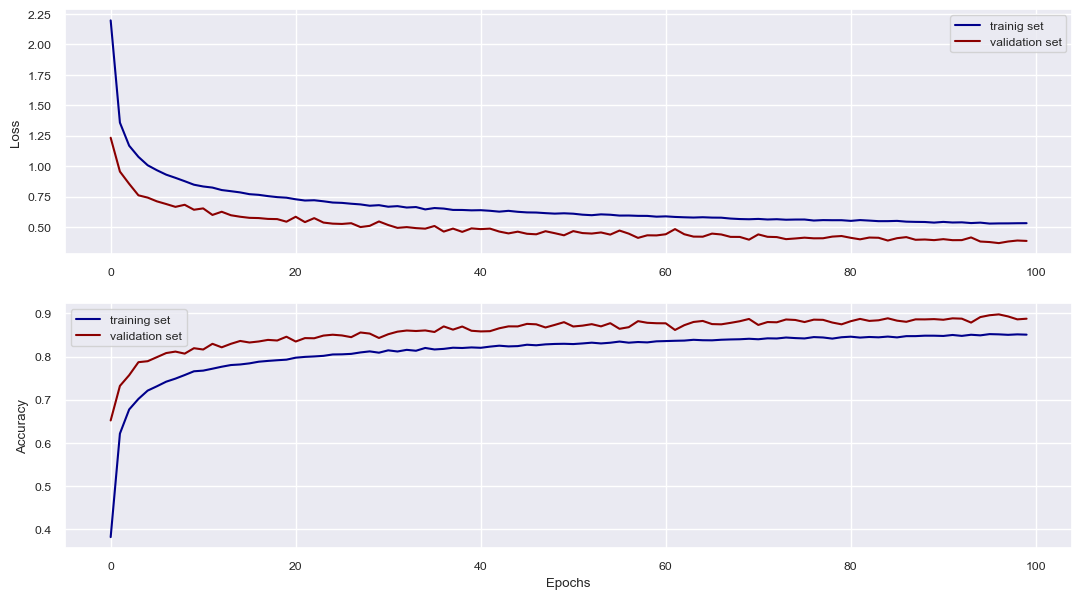

In [44]:
# Plot convergence (loss/accuracy)
training_metrics_plot(history)

**Predict labels in test set**

In [ ]:
# Predict labels in test set
names, real, predicted, probs = apply_test_data(test_data, model)

In [ ]:
# Plot heatmap
confussion_matrix(real, predicted, audio_labels)

In [ ]:
# Overall metrics
accuracy, loss = model.evaluate(test_data.map(extract), verbose = 0)
display_metrics(df, loss, accuracy, audio_dataset, names, total_time, number_epochs, feature_type, noise, noise_level)

# 4. Regularization

As we want the less overfitted model, we will play with two parameters that prevent this: dropout rate and l2 regularization. Here we make a little grid search using different values and plotting a heat map for visualizing the results. Then we choose the best model based on the accuracy and loss and compute some final metrics.

**Set initial values**

In [12]:
# Select audio feature extractor
feature_type = SIFT

# Define background noise
noise = True
noise_level = 0.3
noise_type = "doing_the_dishes"

# Run pipeline
train_data, val_data, test_data = pipeline_setup(audio_dataset, feature_type, noise_type, noise, noise_level)

**Initialize GridSearch**

In [24]:
# Define epochs
dir_models = "./regularization"
epochs = 25
l2_val = [0.1, 0.01, 0.001, 0.0001]
drop_val = [0.1, 0.2, 0.3, 0.4]
# Run model
model_list = []
history_list = []
time_list = []
count = 0
for i in range(len(l2_val)):
    for j in range(len(drop_val)):
    
        model, history, total_time = RNN_model(train_data.map(extract), val_data.map(extract), epochs, l2_val[i], drop_val[j] )
        model.save(f"./regularization/SIFT_RNN_{epochs}_l2{l2_val[i]}_dr{drop_val[j]}.keras")
        history_list.append(history)
        time_list.append(total_time)

        print(f"Combination {count} finished!")

Model Compiled succesfully
Starting training
Epoch 1/25
1158/1158 [==============================] - 27s 19ms/step - loss: 2.7971 - accuracy: 0.3873 - val_loss: 1.5872 - val_accuracy: 0.6224
Epoch 2/25
1158/1158 [==============================] - 21s 18ms/step - loss: 1.4635 - accuracy: 0.6475 - val_loss: 1.1947 - val_accuracy: 0.7149
Epoch 3/25
1158/1158 [==============================] - 22s 18ms/step - loss: 1.2106 - accuracy: 0.7079 - val_loss: 1.0168 - val_accuracy: 0.7521
Epoch 4/25
1158/1158 [==============================] - 22s 18ms/step - loss: 1.0832 - accuracy: 0.7345 - val_loss: 0.9519 - val_accuracy: 0.7683
Epoch 5/25
1158/1158 [==============================] - 22s 19ms/step - loss: 1.0120 - accuracy: 0.7511 - val_loss: 0.8724 - val_accuracy: 0.7866
Epoch 6/25
1158/1158 [==============================] - 24s 20ms/step - loss: 0.9571 - accuracy: 0.7628 - val_loss: 0.8131 - val_accuracy: 0.8010
Epoch 7/25
1158/1158 [==============================] - 23s 20ms/step - loss: 0

2024-07-13 20:03:37.201296: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_14/dropout_29/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 29s 20ms/step - loss: 2.8344 - accuracy: 0.3683 - val_loss: 1.6188 - val_accuracy: 0.6117
Epoch 2/25
1158/1158 [==============================] - 23s 19ms/step - loss: 1.5325 - accuracy: 0.6229 - val_loss: 1.2059 - val_accuracy: 0.7059
Epoch 3/25
1158/1158 [==============================] - 22s 19ms/step - loss: 1.3028 - accuracy: 0.6808 - val_loss: 1.1042 - val_accuracy: 0.7320
Epoch 4/25
1158/1158 [==============================] - 23s 20ms/step - loss: 1.1868 - accuracy: 0.7076 - val_loss: 0.9715 - val_accuracy: 0.7627
Epoch 5/25
1158/1158 [==============================] - 23s 20ms/step - loss: 1.1250 - accuracy: 0.7225 - val_loss: 0.9044 - val_accuracy: 0.7798
Epoch 6/25
1158/1158 [==============================] - 24s 20ms/step - loss: 1.0659 - accuracy: 0.7391 - val_loss: 0.8731 - val_accuracy: 0.7863
Epoch 7/25
1158/1158 [==============================] - 24s 20ms/step - loss: 1.0252 - accuracy: 0.7476 - val_loss: 0.8490 - val_accura

2024-07-13 20:13:43.357885: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_15/dropout_31/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 30s 20ms/step - loss: 2.9186 - accuracy: 0.3388 - val_loss: 1.7258 - val_accuracy: 0.5644
Epoch 2/25
1158/1158 [==============================] - 23s 20ms/step - loss: 1.6972 - accuracy: 0.5751 - val_loss: 1.2642 - val_accuracy: 0.6972
Epoch 3/25
1158/1158 [==============================] - 24s 20ms/step - loss: 1.4499 - accuracy: 0.6389 - val_loss: 1.1215 - val_accuracy: 0.7262
Epoch 4/25
1158/1158 [==============================] - 23s 20ms/step - loss: 1.3302 - accuracy: 0.6691 - val_loss: 1.0936 - val_accuracy: 0.7286
Epoch 5/25
1158/1158 [==============================] - 24s 20ms/step - loss: 1.2536 - accuracy: 0.6876 - val_loss: 1.3947 - val_accuracy: 0.6531
Epoch 6/25
1158/1158 [==============================] - 24s 21ms/step - loss: 1.2041 - accuracy: 0.7023 - val_loss: 1.5201 - val_accuracy: 0.6207
Epoch 7/25
1158/1158 [==============================] - 23s 20ms/step - loss: 1.1506 - accuracy: 0.7154 - val_loss: 0.9445 - val_accura

2024-07-13 20:23:24.545200: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/dropout_33/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 28s 20ms/step - loss: 3.0301 - accuracy: 0.2991 - val_loss: 1.8362 - val_accuracy: 0.5191
Epoch 2/25
1158/1158 [==============================] - 24s 20ms/step - loss: 1.9412 - accuracy: 0.4859 - val_loss: 1.5473 - val_accuracy: 0.6055
Epoch 3/25
1158/1158 [==============================] - 22s 19ms/step - loss: 1.7167 - accuracy: 0.5529 - val_loss: 1.3955 - val_accuracy: 0.6339
Epoch 4/25
1158/1158 [==============================] - 22s 19ms/step - loss: 1.5896 - accuracy: 0.5960 - val_loss: 1.2861 - val_accuracy: 0.6742
Epoch 5/25
1158/1158 [==============================] - 22s 19ms/step - loss: 1.4960 - accuracy: 0.6240 - val_loss: 1.1746 - val_accuracy: 0.7049
Epoch 6/25
1158/1158 [==============================] - 23s 20ms/step - loss: 1.4217 - accuracy: 0.6444 - val_loss: 1.0884 - val_accuracy: 0.7369
Epoch 7/25
1158/1158 [==============================] - 23s 20ms/step - loss: 1.3723 - accuracy: 0.6592 - val_loss: 1.0608 - val_accura

2024-07-13 20:33:17.114901: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_17/dropout_35/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 29s 21ms/step - loss: 1.9638 - accuracy: 0.4898 - val_loss: 1.1602 - val_accuracy: 0.7024
Epoch 2/25
1158/1158 [==============================] - 21s 18ms/step - loss: 1.1445 - accuracy: 0.7018 - val_loss: 0.9360 - val_accuracy: 0.7655
Epoch 3/25
1158/1158 [==============================] - 21s 18ms/step - loss: 0.9779 - accuracy: 0.7434 - val_loss: 0.8123 - val_accuracy: 0.7899
Epoch 4/25
1158/1158 [==============================] - 21s 18ms/step - loss: 0.8948 - accuracy: 0.7649 - val_loss: 0.7648 - val_accuracy: 0.7971
Epoch 5/25
1158/1158 [==============================] - 23s 19ms/step - loss: 0.8398 - accuracy: 0.7788 - val_loss: 0.7063 - val_accuracy: 0.8125
Epoch 6/25
1158/1158 [==============================] - 22s 19ms/step - loss: 0.7932 - accuracy: 0.7891 - val_loss: 0.6582 - val_accuracy: 0.8285
Epoch 7/25
1158/1158 [==============================] - 23s 19ms/step - loss: 0.7687 - accuracy: 0.7951 - val_loss: 0.6572 - val_accura

2024-07-13 20:43:28.617295: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_18/dropout_37/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 31s 21ms/step - loss: 2.1231 - accuracy: 0.4412 - val_loss: 1.2020 - val_accuracy: 0.6968
Epoch 2/25
1158/1158 [==============================] - 24s 20ms/step - loss: 1.2828 - accuracy: 0.6603 - val_loss: 0.9906 - val_accuracy: 0.7448
Epoch 3/25
1158/1158 [==============================] - 24s 20ms/step - loss: 1.1052 - accuracy: 0.7070 - val_loss: 0.8843 - val_accuracy: 0.7662
Epoch 4/25
1158/1158 [==============================] - 24s 20ms/step - loss: 1.0198 - accuracy: 0.7290 - val_loss: 0.8081 - val_accuracy: 0.7853
Epoch 5/25
1158/1158 [==============================] - 23s 20ms/step - loss: 0.9606 - accuracy: 0.7454 - val_loss: 0.7862 - val_accuracy: 0.7870
Epoch 6/25
1158/1158 [==============================] - 23s 20ms/step - loss: 0.9174 - accuracy: 0.7554 - val_loss: 0.7327 - val_accuracy: 0.8039
Epoch 7/25
1158/1158 [==============================] - 23s 20ms/step - loss: 0.8837 - accuracy: 0.7638 - val_loss: 0.7057 - val_accura

2024-07-13 20:53:24.465928: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_39/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 28s 20ms/step - loss: 2.3506 - accuracy: 0.3717 - val_loss: 1.4048 - val_accuracy: 0.6232
Epoch 2/25
1158/1158 [==============================] - 21s 18ms/step - loss: 1.4975 - accuracy: 0.5979 - val_loss: 1.1115 - val_accuracy: 0.7003
Epoch 3/25
1158/1158 [==============================] - 21s 18ms/step - loss: 1.2873 - accuracy: 0.6583 - val_loss: 0.9958 - val_accuracy: 0.7362
Epoch 4/25
1158/1158 [==============================] - 22s 19ms/step - loss: 1.1773 - accuracy: 0.6858 - val_loss: 0.9639 - val_accuracy: 0.7444
Epoch 5/25
1158/1158 [==============================] - 21s 18ms/step - loss: 1.1163 - accuracy: 0.7029 - val_loss: 0.8526 - val_accuracy: 0.7758
Epoch 6/25
1158/1158 [==============================] - 21s 18ms/step - loss: 1.0653 - accuracy: 0.7167 - val_loss: 0.8105 - val_accuracy: 0.7834
Epoch 7/25
1158/1158 [==============================] - 22s 19ms/step - loss: 1.0198 - accuracy: 0.7291 - val_loss: 0.7589 - val_accura

2024-07-13 21:02:47.196022: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_20/dropout_41/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 28s 20ms/step - loss: 2.5211 - accuracy: 0.3173 - val_loss: 1.5508 - val_accuracy: 0.5785
Epoch 2/25
1158/1158 [==============================] - 24s 20ms/step - loss: 1.6580 - accuracy: 0.5550 - val_loss: 1.2614 - val_accuracy: 0.6649
Epoch 3/25
1158/1158 [==============================] - 22s 19ms/step - loss: 1.4297 - accuracy: 0.6203 - val_loss: 1.0289 - val_accuracy: 0.7293
Epoch 4/25
1158/1158 [==============================] - 23s 19ms/step - loss: 1.3174 - accuracy: 0.6513 - val_loss: 0.9829 - val_accuracy: 0.7371
Epoch 5/25
1158/1158 [==============================] - 23s 19ms/step - loss: 1.2496 - accuracy: 0.6701 - val_loss: 0.9729 - val_accuracy: 0.7394
Epoch 6/25
1158/1158 [==============================] - 23s 19ms/step - loss: 1.1972 - accuracy: 0.6851 - val_loss: 0.8957 - val_accuracy: 0.7588
Epoch 7/25
1158/1158 [==============================] - 22s 19ms/step - loss: 1.1531 - accuracy: 0.6963 - val_loss: 0.8371 - val_accura

2024-07-13 21:12:24.386267: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_21/dropout_43/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 28s 19ms/step - loss: 1.8177 - accuracy: 0.4929 - val_loss: 1.1378 - val_accuracy: 0.6840
Epoch 2/25
1158/1158 [==============================] - 22s 19ms/step - loss: 1.0388 - accuracy: 0.7110 - val_loss: 0.8220 - val_accuracy: 0.7717
Epoch 3/25
1158/1158 [==============================] - 22s 19ms/step - loss: 0.8856 - accuracy: 0.7538 - val_loss: 0.7275 - val_accuracy: 0.7977
Epoch 4/25
1158/1158 [==============================] - 23s 20ms/step - loss: 0.8153 - accuracy: 0.7730 - val_loss: 0.6700 - val_accuracy: 0.8146
Epoch 5/25
1158/1158 [==============================] - 22s 19ms/step - loss: 0.7570 - accuracy: 0.7879 - val_loss: 0.6346 - val_accuracy: 0.8236
Epoch 6/25
1158/1158 [==============================] - 22s 19ms/step - loss: 0.7231 - accuracy: 0.7963 - val_loss: 0.6312 - val_accuracy: 0.8252
Epoch 7/25
1158/1158 [==============================] - 22s 19ms/step - loss: 0.6917 - accuracy: 0.8035 - val_loss: 0.5693 - val_accura

2024-07-13 21:22:06.057699: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_22/dropout_45/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 32s 21ms/step - loss: 1.9770 - accuracy: 0.4465 - val_loss: 1.1988 - val_accuracy: 0.6680
Epoch 2/25
1158/1158 [==============================] - 23s 20ms/step - loss: 1.2421 - accuracy: 0.6517 - val_loss: 0.9355 - val_accuracy: 0.7436
Epoch 3/25
1158/1158 [==============================] - 22s 19ms/step - loss: 1.0497 - accuracy: 0.7071 - val_loss: 0.8121 - val_accuracy: 0.7692
Epoch 4/25
1158/1158 [==============================] - 22s 19ms/step - loss: 0.9547 - accuracy: 0.7337 - val_loss: 0.7411 - val_accuracy: 0.7937
Epoch 5/25
1158/1158 [==============================] - 22s 19ms/step - loss: 0.8955 - accuracy: 0.7494 - val_loss: 0.6893 - val_accuracy: 0.8101
Epoch 6/25
1158/1158 [==============================] - 23s 20ms/step - loss: 0.8570 - accuracy: 0.7599 - val_loss: 0.6880 - val_accuracy: 0.8053
Epoch 7/25
1158/1158 [==============================] - 23s 20ms/step - loss: 0.8201 - accuracy: 0.7709 - val_loss: 0.6159 - val_accura

2024-07-13 21:31:56.313494: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_23/dropout_47/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 30s 21ms/step - loss: 2.2895 - accuracy: 0.3581 - val_loss: 1.4291 - val_accuracy: 0.5963
Epoch 2/25
1158/1158 [==============================] - 23s 19ms/step - loss: 1.4085 - accuracy: 0.6035 - val_loss: 0.9719 - val_accuracy: 0.7258
Epoch 3/25
1158/1158 [==============================] - 24s 20ms/step - loss: 1.1956 - accuracy: 0.6665 - val_loss: 0.8591 - val_accuracy: 0.7558
Epoch 4/25
1158/1158 [==============================] - 24s 20ms/step - loss: 1.0972 - accuracy: 0.6953 - val_loss: 0.8025 - val_accuracy: 0.7708
Epoch 5/25
1158/1158 [==============================] - 23s 20ms/step - loss: 1.0297 - accuracy: 0.7138 - val_loss: 0.7608 - val_accuracy: 0.7857
Epoch 6/25
1158/1158 [==============================] - 24s 20ms/step - loss: 0.9854 - accuracy: 0.7245 - val_loss: 0.7248 - val_accuracy: 0.7959
Epoch 7/25
1158/1158 [==============================] - 24s 21ms/step - loss: 0.9461 - accuracy: 0.7375 - val_loss: 0.7116 - val_accura

2024-07-13 21:41:54.935902: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_24/dropout_49/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 28s 20ms/step - loss: 2.2691 - accuracy: 0.3693 - val_loss: 1.3359 - val_accuracy: 0.6227
Epoch 2/25
1158/1158 [==============================] - 23s 19ms/step - loss: 1.5185 - accuracy: 0.5792 - val_loss: 1.0810 - val_accuracy: 0.6987
Epoch 3/25
1158/1158 [==============================] - 23s 19ms/step - loss: 1.3271 - accuracy: 0.6330 - val_loss: 0.9666 - val_accuracy: 0.7263
Epoch 4/25
1158/1158 [==============================] - 23s 20ms/step - loss: 1.2262 - accuracy: 0.6616 - val_loss: 0.8617 - val_accuracy: 0.7579
Epoch 5/25
1158/1158 [==============================] - 23s 20ms/step - loss: 1.1582 - accuracy: 0.6812 - val_loss: 0.8878 - val_accuracy: 0.7475
Epoch 6/25
1158/1158 [==============================] - 23s 19ms/step - loss: 1.1107 - accuracy: 0.6952 - val_loss: 0.8395 - val_accuracy: 0.7654
Epoch 7/25
1158/1158 [==============================] - 22s 19ms/step - loss: 1.0744 - accuracy: 0.7051 - val_loss: 0.8283 - val_accura

2024-07-13 21:51:46.570682: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_25/dropout_51/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 29s 20ms/step - loss: 1.8284 - accuracy: 0.4731 - val_loss: 1.0604 - val_accuracy: 0.6912
Epoch 2/25
1158/1158 [==============================] - 23s 20ms/step - loss: 0.9837 - accuracy: 0.7101 - val_loss: 0.7855 - val_accuracy: 0.7615
Epoch 3/25
1158/1158 [==============================] - 25s 21ms/step - loss: 0.8401 - accuracy: 0.7517 - val_loss: 0.6864 - val_accuracy: 0.7981
Epoch 4/25
1158/1158 [==============================] - 24s 21ms/step - loss: 0.7619 - accuracy: 0.7765 - val_loss: 0.6187 - val_accuracy: 0.8169
Epoch 5/25
1158/1158 [==============================] - 24s 20ms/step - loss: 0.7127 - accuracy: 0.7910 - val_loss: 0.5886 - val_accuracy: 0.8272
Epoch 6/25
1158/1158 [==============================] - 24s 20ms/step - loss: 0.6753 - accuracy: 0.8025 - val_loss: 0.5321 - val_accuracy: 0.8432
Epoch 7/25
1158/1158 [==============================] - 24s 20ms/step - loss: 0.6520 - accuracy: 0.8075 - val_loss: 0.5326 - val_accura

2024-07-13 22:02:11.142410: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_26/dropout_53/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 31s 22ms/step - loss: 1.8729 - accuracy: 0.4563 - val_loss: 1.0738 - val_accuracy: 0.6852
Epoch 2/25
1158/1158 [==============================] - 24s 20ms/step - loss: 1.1279 - accuracy: 0.6695 - val_loss: 0.8439 - val_accuracy: 0.7493
Epoch 3/25
1158/1158 [==============================] - 24s 20ms/step - loss: 0.9708 - accuracy: 0.7184 - val_loss: 0.7457 - val_accuracy: 0.7795
Epoch 4/25
1158/1158 [==============================] - 23s 20ms/step - loss: 0.8867 - accuracy: 0.7410 - val_loss: 0.6920 - val_accuracy: 0.7925
Epoch 5/25
1158/1158 [==============================] - 24s 20ms/step - loss: 0.8402 - accuracy: 0.7561 - val_loss: 0.6406 - val_accuracy: 0.8109
Epoch 6/25
1158/1158 [==============================] - 24s 20ms/step - loss: 0.7982 - accuracy: 0.7680 - val_loss: 0.5962 - val_accuracy: 0.8261
Epoch 7/25
1158/1158 [==============================] - 24s 21ms/step - loss: 0.7682 - accuracy: 0.7763 - val_loss: 0.5917 - val_accura

2024-07-13 22:12:36.395554: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_27/dropout_55/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 33s 22ms/step - loss: 2.1344 - accuracy: 0.3898 - val_loss: 1.2352 - val_accuracy: 0.6308
Epoch 2/25
1158/1158 [==============================] - 24s 20ms/step - loss: 1.3705 - accuracy: 0.6012 - val_loss: 1.0060 - val_accuracy: 0.7013
Epoch 3/25
1158/1158 [==============================] - 25s 21ms/step - loss: 1.1724 - accuracy: 0.6603 - val_loss: 0.8608 - val_accuracy: 0.7478
Epoch 4/25
1158/1158 [==============================] - 24s 21ms/step - loss: 1.0822 - accuracy: 0.6875 - val_loss: 0.8087 - val_accuracy: 0.7631
Epoch 5/25
1158/1158 [==============================] - 24s 21ms/step - loss: 1.0037 - accuracy: 0.7100 - val_loss: 0.7423 - val_accuracy: 0.7814
Epoch 6/25
1158/1158 [==============================] - 25s 21ms/step - loss: 0.9610 - accuracy: 0.7205 - val_loss: 0.7411 - val_accuracy: 0.7831
Epoch 7/25
1158/1158 [==============================] - 26s 22ms/step - loss: 0.9198 - accuracy: 0.7351 - val_loss: 0.7153 - val_accura

2024-07-13 22:23:09.021075: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_28/dropout_57/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 31s 21ms/step - loss: 2.2971 - accuracy: 0.3448 - val_loss: 1.3009 - val_accuracy: 0.6177
Epoch 2/25
1158/1158 [==============================] - 23s 20ms/step - loss: 1.4947 - accuracy: 0.5695 - val_loss: 0.9777 - val_accuracy: 0.7137
Epoch 3/25
1158/1158 [==============================] - 23s 20ms/step - loss: 1.2947 - accuracy: 0.6309 - val_loss: 0.9099 - val_accuracy: 0.7329
Epoch 4/25
1158/1158 [==============================] - 23s 20ms/step - loss: 1.1819 - accuracy: 0.6635 - val_loss: 0.8803 - val_accuracy: 0.7402
Epoch 5/25
1158/1158 [==============================] - 23s 20ms/step - loss: 1.1108 - accuracy: 0.6835 - val_loss: 0.7802 - val_accuracy: 0.7726
Epoch 6/25
1158/1158 [==============================] - 24s 20ms/step - loss: 1.0704 - accuracy: 0.6967 - val_loss: 0.7857 - val_accuracy: 0.7673
Epoch 7/25
1158/1158 [==============================] - 24s 21ms/step - loss: 1.0341 - accuracy: 0.7077 - val_loss: 0.7558 - val_accura

In [38]:
# Save history files
for i in range(16):
    # Display training metrics dataframe
    df = pd.DataFrame(history_list[i].history)
    df.to_csv(os.path.join(df_path, f'{i}.txt'), sep='\t', index=False)
    df.tail()
    
# Save time values
np.savetxt( "timelist.txt", time_list)

**Show heatmap**

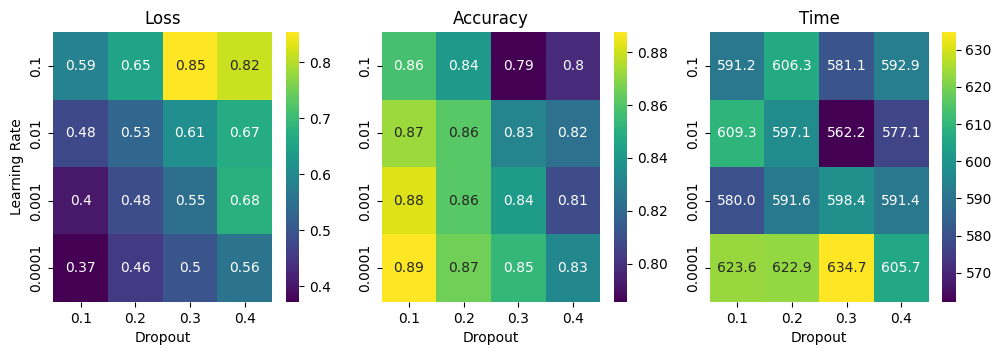

In [8]:
res_lr_dp = pd.concat([pd.read_csv("./regularization/0.txt", delimiter='\t')[-1:],
           pd.read_csv("./regularization/1.txt", delimiter='\t')[-1:],
           pd.read_csv("./regularization/2.txt", delimiter='\t')[-1:],
           pd.read_csv("./regularization/3.txt", delimiter='\t')[-1:],
           pd.read_csv("./regularization/4.txt", delimiter='\t')[-1:],
           pd.read_csv("./regularization/5.txt", delimiter='\t')[-1:],
           pd.read_csv("./regularization/6.txt", delimiter='\t')[-1:],
           pd.read_csv("./regularization/7.txt", delimiter='\t')[-1:],
           pd.read_csv("./regularization/8.txt", delimiter='\t')[-1:],
           pd.read_csv("./regularization/9.txt", delimiter='\t')[-1:],
           pd.read_csv("./regularization/10.txt", delimiter='\t')[-1:],
           pd.read_csv("./regularization/11.txt", delimiter='\t')[-1:],
           pd.read_csv("./regularization/12.txt", delimiter='\t')[-1:],
           pd.read_csv("./regularization/13.txt", delimiter='\t')[-1:],
           pd.read_csv("./regularization/14.txt", delimiter='\t')[-1:],
           pd.read_csv("./regularization/15.txt", delimiter='\t')[-1:]]).reset_index(drop=True)

time_lr_dp = pd.read_csv("./regularization/timelist.txt", header=None)

l2_val = [0.1, 0.01, 0.001, 0.0001]
drop_val = [0.1, 0.2, 0.3, 0.4]

loss_lr_dp = np.array(res_lr_dp['val_loss']).reshape((4, 4))
accu_lr_dp = np.array(res_lr_dp['val_accuracy']).reshape((4, 4))
time_lr_dp = np.array(time_lr_dp).reshape((4, 4))


fig, axis = plt.subplots(1, 3, figsize=(12, 3.5))
axis = axis.flatten()

sns.heatmap(loss_lr_dp, cmap="viridis", cbar=True, annot=True, xticklabels=drop_val, yticklabels=l2_val, ax = axis[0]) 
sns.heatmap(accu_lr_dp, cmap="viridis", cbar=True, annot=True, xticklabels=drop_val, yticklabels=l2_val, ax = axis[1]) 
sns.heatmap(time_lr_dp, cmap="viridis", cbar=True, annot=True, xticklabels=drop_val, yticklabels=l2_val, fmt=".1f", ax = axis[2]) 

# Set the labels
axis[0].set_title('Loss')
axis[0].set_xlabel('Dropout')
axis[0].set_ylabel('Learning Rate')

# Set the labels
axis[1].set_title('Accuracy')
axis[1].set_xlabel('Dropout')

# Set the labels
axis[2].set_title('Time')
axis[2].set_xlabel('Dropout')

plt.show()

Best model is defined but the highest accuracy but also for the less consumption in time. Then the best one is: dropout = 0.3 and lr = 0.01

In [7]:
# Predict labels in test set
model = tf.keras.models.load_model("./regularization/SIFT_RNN_25_l20.01_dr0.3.keras", safe_mode = False)
names, real, predicted, probs = apply_test_data(test_data, model)

2024-07-13 23:56:27.472129: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


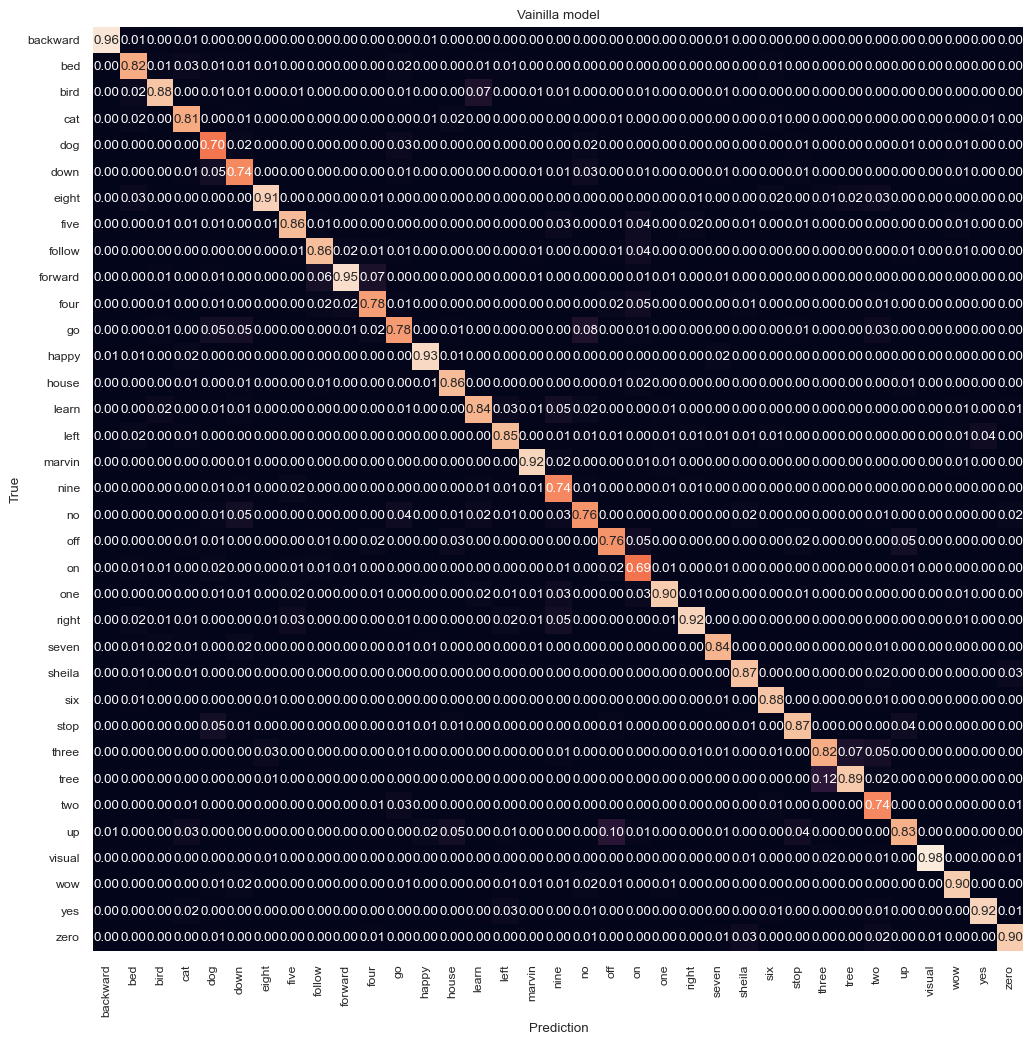

In [8]:
# Plot heatmap
confussion_matrix(real, predicted, audio_labels)